### Librerias y paquetes

#### *Entorno virtuales*

In [1]:
# Create and activate virtual env for speech processing stage
!python3 -m venv proc_habla
!source proc_habla/bin/activate

#### *Instalacion*

In [2]:
# title dependencias previas
!pip3 install conllu
!pip3 install import-ipynb

#### *Importacion*

In [3]:
import spacy
from spacy.training import Example
from spacy.util import minibatch
import random
import conllu
from conllu import parse_incr
from funciones_comunes.common_functions import procesar_texto
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### Lectura de datos

#### *Corpus*
Se descarga el corpus mas actualizado y en español que se pudo encontrar (2024), se espera para futuras versiones poder hacer evaluacion con corpus especializados en el mercado al que esta destinado el ChatBot

In [4]:
!git clone https://github.com/UniversalDependencies/UD_Spanish-AnCora.git

fatal: destination path 'UD_Spanish-AnCora' already exists and is not an empty directory.


In [5]:
real_tokens = []
corpus_text = ''

In [6]:
# lista con oraciones del corpus
oraciones = []

# abro el corpus
with open("UD_Spanish-AnCora/es_ancora-ud-dev.conllu", "r", encoding="utf-8") as data_file:
    corpus = parse_incr(data_file)
    # Recorro el corpus y almaceno cada oracion del mismo en la lista 'oraciones'
    for tokenlist in parse_incr(data_file):
        oraciones.append(tokenlist)

In [7]:
# almaceno cada token de cada oracion en una lista especializada
for token in tokenlist:
    real_tokens.append(token['form'])

## Codigo general a todas las etapas

In [8]:
nlp = spacy.load("es_core_news_sm")

In [9]:
# Concatena todos los tokens en una sola cadena de texto
all_text = " ".join(real_tokens)

In [10]:
spacy_text = procesar_texto(all_text, nlp=nlp)

In [11]:
spacy_tokens_all_text = spacy_text['tokens']

## Evaluación de etiquetado de secuencias

Se evalúa qué tan bien el modelo pre-entrenado de spaCy puede asignar etiquetas de partes del discurso correctas a cada palabra en una oración.

In [12]:
oraciones_mal_tokenizadas = 0

In [14]:
# Se almacena en formato admitido por spaCy, los tokens y etiquetas de el corpus de ancora.

examples = []

# reccorro cada oracion 
for oracion in oraciones:
    # almaceno en la lista 'words' las palabras/tokens de la oracion actual (etiquetadas asi en el corpus)
    words = [token['form'] for token in oracion]
    lemmas = [token['lemma'] for token in oracion]
    # almaceno en la lista 'pos_tags' las etiquetas gramaticales de cada palabra/token de la oracion actual (etiquetadas asi en el corpus)
    pos_tags = [token['upostag'] for token in oracion]
    
    # Aseguro que la tokenización coincida entre spaCy y conllu (por lo que de momento sera util para comprobar el etiquetado gramatical)
    # vuelco en la variable 'doc' todas los tokens de la oracion
    doc_spacy = nlp.make_doc(" ".join(words))
    # almaceno en doc_spacy_tokens, la variable los tokens previos
    doc_spacy_tokens = [token.text for token in doc_spacy]
    # Obtengo los lemas de los tokens previos
    doc_spacy_lemmas = [token.lemma_ for token in doc_spacy]
    # Si spacy tokeniza de manera diferente a lo que se espera en el corpus, se cuenta como oracion mal tokenizada
    if len(doc_spacy_tokens) != len(pos_tags):
        oraciones_mal_tokenizadas +=1
        continue
    
    # Se crea el formato de entrada y salida de spaCy para su posterior evaluacion
    example = Example.from_dict(doc_spacy, {"tags": pos_tags})
    examples.append(example)

In [15]:
# Separo un conjunto de evaluación tomando 10% del corpus
random.shuffle(examples)
split = int(len(examples) * 0.9)
train_data = examples[:split]
eval_data = examples[split:]

In [16]:
# Evaluo el modelo con los datos de evaluación

scorer = nlp.evaluate(eval_data)

In [17]:
scorer['tag_acc']

0.9423182567295367

## Evaluacion de tokenización
Se comprueba si el texto se divide correctamente en palabras y puntuaciones.

In [20]:
porcentaje_acierto_tokenizacion = (len(oraciones)-oraciones_mal_tokenizadas) * 100 / len(oraciones)

In [21]:
porcentaje_acierto_tokenizacion

99.03264812575574

## Evaluacion de Lematización
Se verifica la presicion con la que Spacy asigna correctamente el lema a cada palabra.

In [22]:
'''
# Comparar las lematizaciones generadas por spaCy con las lematizaciones reales del corpus
correct_count = sum(1 for doc_spacy_lemma, lemma in zip(doc_spacy_lemmas, lemmas) if doc_spacy_lemma == lemma)
total_count = len(lemmas)

# Calcular la precisión de la lematización
precision = correct_count / total_count
print("Precision:", precision)
'''

'\n# Comparar las lematizaciones generadas por spaCy con las lematizaciones reales del corpus\ncorrect_count = sum(1 for doc_spacy_lemma, lemma in zip(doc_spacy_lemmas, lemmas) if doc_spacy_lemma == lemma)\ntotal_count = len(lemmas)\n\n# Calcular la precisión de la lematización\nprecision = correct_count / total_count\nprint("Precision:", precision)\n'

## Graficos de las diferentes evaluaciones

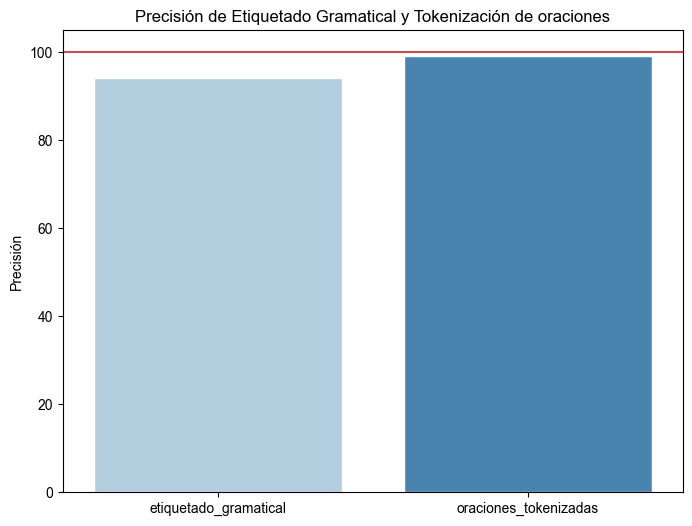

In [23]:
# Se obtienen los valores de precisión
precision_etiquetado = scorer['tag_acc'] * 100
precision_tokenizacion = porcentaje_acierto_tokenizacion

# Se crea un DataFrame de Pandas con los valores de precisión
data = pd.DataFrame({'etiquetado_gramatical': [precision_etiquetado], 'oraciones_tokenizadas': [precision_tokenizacion]})
# Se establece un índice explícito
data.index = ['Precisión']  # Establecer un índice explícito

# Se crea un gráfico de barras utilizando Seaborn
# Tamaño del grafico
plt.figure(figsize=(8, 6))
# Altura de la linea horizontal que fijara el 100%
plt.axhline(100, color='r')
# Estilo del grafico de barras y cuadricula
sns.set(style="whitegrid")
sns.barplot(data=data, palette="Blues")

# Título al gráfico
plt.title("Precisión de Etiquetado Gramatical y Tokenización de oraciones")

plt.ylabel('Precisión')
plt.show()

### Observaciones

Etiquetado Gramatical:

La herramienta spaCy ha demostrado una alta precisión en el etiquetado gramatical de los tokens, alcanzando una precisión del 94.23%. Esto indica que en la mayoría de los casos, spaCy identifica correctamente las partes del discurso (sustantivos, verbos, adjetivos, etc.) de cada palabra dentro del texto analizado.

Tokenización de Oraciones:

En cuanto a la tokenización de oraciones, spaCy proporciona una fiabilidad del 99.03% cuando se compara con la tokenización manual o "real". Esto sugiere que spaCy es muy eficiente al dividir el texto en oraciones, asegurando que la gran mayoría de las oraciones se segmentan correctamente de acuerdo con las expectativas humanas.